In [383]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import scipy as sp
from sklearn.linear_model import  LassoCV, Lasso
from sklearn.model_selection import cross_val_score

In [240]:
#load the data
train_df = pd.read_csv('./train.csv')
test_df = pd.read_csv('./test.csv')

In [241]:
# a quick glimpse
print train_df.head()
print train_df.shape
print test_df.shape

   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities    ...     PoolArea PoolQC Fence MiscFeature MiscVal  \
0         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
1         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
2         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
3         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
4         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   

  MoSold YrSold  SaleType  SaleCondition  SalePrice  
0      2   2008     

In [242]:
#examine null values 
print train_df.isnull().sum()

Id                  0
MSSubClass          0
MSZoning            0
LotFrontage       259
LotArea             0
Street              0
Alley            1369
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType          8
MasVnrArea          8
ExterQual           0
ExterCond           0
Foundation          0
                 ... 
BedroomAbvGr        0
KitchenAbvGr        0
KitchenQual         0
TotRmsAbvGrd        0
Functional          0
Fireplaces          0
FireplaceQu       690
GarageType         81
GarageYrBlt        81
GarageFinish       81
GarageCars          0
GarageArea          0
GarageQual         81
GarageCond         81
PavedDrive

<b>Let's take a quick look at the target variable distribution.</b>

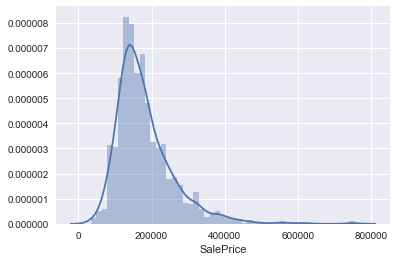

In [243]:
sns.distplot((train_df['SalePrice']))

The distribution seems slightly skewed. 
Starting off by doing a log transform on the target variable to make the distrobution less skewed.

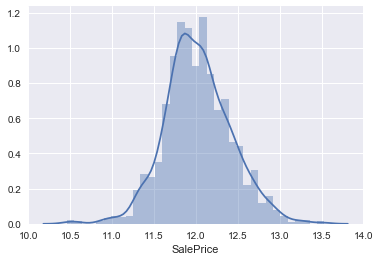

In [244]:
sns.distplot(np.log(train_df['SalePrice']))
train_df['SalePrice'] = np.log(train_df['SalePrice'])

Let's check the skew for various numerical features and fix them if necessary.

In [245]:
train_df.skew().sort_values(ascending=False)

MiscVal          24.476794
PoolArea         14.828374
LotArea          12.207688
3SsnPorch        10.304342
LowQualFinSF      9.011341
KitchenAbvGr      4.488397
BsmtFinSF2        4.255261
ScreenPorch       4.122214
BsmtHalfBath      4.103403
EnclosedPorch     3.089872
MasVnrArea        2.669084
OpenPorchSF       2.364342
LotFrontage       2.163569
BsmtFinSF1        1.685503
WoodDeckSF        1.541376
TotalBsmtSF       1.524255
MSSubClass        1.407657
1stFlrSF          1.376757
GrLivArea         1.366560
BsmtUnfSF         0.920268
2ndFlrSF          0.813030
OverallCond       0.693067
TotRmsAbvGrd      0.676341
HalfBath          0.675897
Fireplaces        0.649565
BsmtFullBath      0.596067
OverallQual       0.216944
MoSold            0.212053
BedroomAbvGr      0.211790
GarageArea        0.179981
SalePrice         0.121335
YrSold            0.096269
FullBath          0.036562
Id                0.000000
GarageCars       -0.342549
YearRemodAdd     -0.503562
YearBuilt        -0.613461
G

We see that some of the features have very high skew. Doing a log transform would make them more normally distributed.

In [246]:
def reduce_skew(df):
    features = df.dtypes[df.dtypes != 'object'].index
    sk = df[features].apply(lambda x: sp.stats.skew(x.dropna()))
    sk = sk[sk>0.8]
    sk = sk.index
    return sk
    

In [247]:
#omitting SalePrice Column remove skew from train and test data
skewfeat = reduce_skew(train_df.loc[:,'MSSubClass':'SaleCondition'])
train_df[skewfeat] = np.log1p(train_df[skewfeat])
testskew = reduce_skew(test_df.loc[:,'MSSubClass':'SaleCondition'])
test_df[testskew] = np.log1p(test_df[testskew])

In [249]:
#handling categorical data: with 1 hot encoding
full_df = pd.concat((train_df.loc[:,'MSSubClass':'SaleCondition'], test_df.loc[:,'MSSubClass':'SaleCondition']))
full_df = pd.get_dummies(full_df)


In [250]:
#Taking care of the NaNs
full_df= full_df.fillna(full_df.mean())

In [261]:
#Create the test and the train data
X_train = full_df[:train_df.shape[0]]
X_test = full_df[test_df.shape[0]:]
y_train= train_df.SalePrice

Trying a LassoCV model, since it can select features and also determine the alpha value

In [323]:
alphas = [0.0001,0.0005,0.01,.05, 0.1, 1, 5, 10, 30 , 50 , 75, 100]

In [438]:
lasso = LassoCV(alphas = [0.0001,0.0005,0.01,.05, 0.1, 1, 5, 10, 30 , 50 , 75, 100] ).fit(X_train, y_train)
#lasso = LassoCV().fit(X_train,y_train)

In [439]:
rmserro = np.sqrt(-cross_val_score(lasso, X_train, y_train, scoring="neg_mean_squared_error", cv = 5)).mean()

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [441]:
print rmserro
print lasso.alpha_

0.122473182317
0.0005


In [394]:
#Lasso coefficients to see which features got selected
coef = pd.Series(lasso.coef_, index = X_train.columns)
coef = coef[coef!=0]
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)]).reset_index()
imp_coef.columns = ['feature', 'coef']

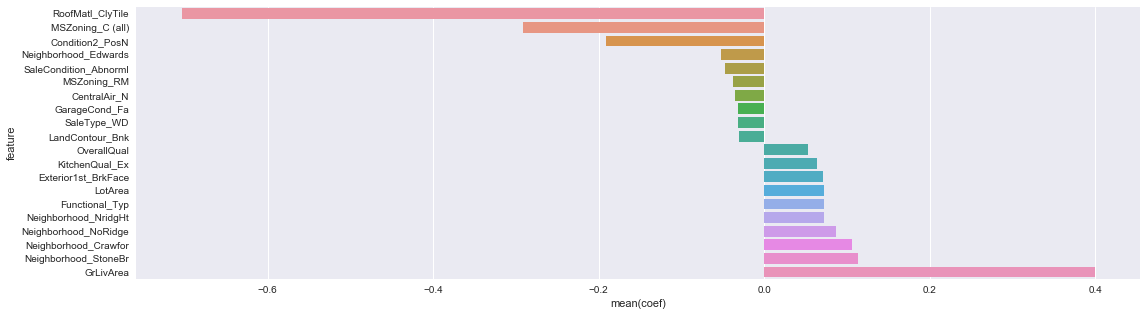

In [395]:
fig ,ax = plt.subplots(nrows=1,ncols=1, figsize=(18,5))
sns.barplot("coef", 'feature', data=imp_coef, ax=ax)


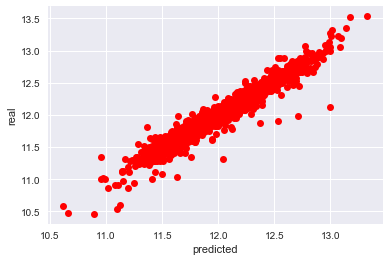

In [429]:
#A quick plot to see how our prediction was in comparison to the actual value
plt.plot(lasso.predict(X_train), y_train, 'ro')
plt.xlabel('predicted')
plt.ylabel('real')
plt.show()

In [442]:
y_pred = (lasso.predict(X_test))
y_pred = np.exp(y_pred)

In [451]:
#predicted values for the test data
list(y_pred)

[141039.31808927556,
 120110.98420539923,
 150363.9751074877,
 177603.19617017949,
 194011.45243900287,
 200634.41912240087,
 167344.61589939284,
 176818.37764053352,
 156547.62242538607,
 194822.82608817201,
 119081.76424795206,
 183964.62974798656,
 97553.77542898964,
 93474.547992373133,
 140129.00168717906,
 106890.17780469879,
 345775.25470371556,
 245349.75249428622,
 296573.35551056766,
 294145.99881487631,
 452557.27158056461,
 318464.52541203721,
 209248.94142702583,
 180886.24459341454,
 158768.536632926,
 193383.82723145952,
 190849.28728208036,
 328983.91001291689,
 236219.04122303403,
 191175.49993818763,
 237473.62734501096,
 194111.41104414512,
 92367.648684146581,
 183023.74674038609,
 288659.79332897218,
 285112.87945248903,
 227857.9059773492,
 179603.9401977034,
 170530.43753518368,
 164479.23627555094,
 157198.34866768392,
 170902.61891500314,
 144637.82666648098,
 281401.28636243398,
 237270.07415697866,
 223298.30299558022,
 182821.89149847737,
 237824.23062946537